
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2024.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/ahoust17/MLSTEM2024//main/Day1/Atom_Segmentation.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/ahoust17/MLSTEM2024/blob/main/Day1/Atom_Segmention.ipynb)
# Training a U-Net to Segment Noisy Atomic Resolution Images

**Speaker: Austin Houston**

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>

<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

Install AtomAI:

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('installing atomai')
!pip install git+https://github.com/pycroscopy/atomai

print('installing DataGenSTEM')
!git clone https://github.com/ahoust17/DataGenSTEM.git


%matplotlib widget

import matplotlib.pylab as plt
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
    from  google.colab import drive 
    from google.colab import output
    output.enable_custom_widget_manager()

import pyTEMlib.file_tools      
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools 
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

print('installing DataGenSTEM')
!git clone https://github.com/ahoust17/DataGenSTEM.git


sys.path.append('./DataGenSTEM/DataGenSTEM')
import data_generator as dg

import atomai as aoi

Imports:

## Semantic segmentation

Download training/test data:

In [5]:
# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('/Users/austin/Desktop/training_data.npz')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']


print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)


(80, 256, 256) (80, 256, 256)
(20, 256, 256) (20, 256, 256)


In [3]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    if not os.path.exists('./STO_Stack_10.dm3'):
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/STO_Stack_10.dm3
        
fileWidget = pyTEMlib.file_tools.FileWidget()

(80, 256, 256) (80, 256, 256)
(20, 256, 256) (20, 256, 256)


In [ ]:
datasets = fileWidget.datasets
dataset = fileWidget.selected_dataset
# dataset = datasets['Channel_000']
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image stack')
dataset.x.dimension_type = 'spatial'
dataset.y.dimension_type = 'spatial'
dataset.set_dimension
view = dataset.plot()

In [ ]:
# normalization
dataset -= np.min(dataset)
dataset /= np.max(dataset)

print('Shape:', dataset.shape)

pixel_size = dataset.original_metadata['BinaryResult']['PixelSize']['width']*10^10 # 'Angstrom/pixel'
print('Pixel size:', pixel_size, 'Angstrom/pixel')

In [ ]:
image_array = np.array(dataset)[0]
expdata = dg.shotgun_crop(image_array, crop_size=512, n_crops=5)

Let's plot some of the training data:

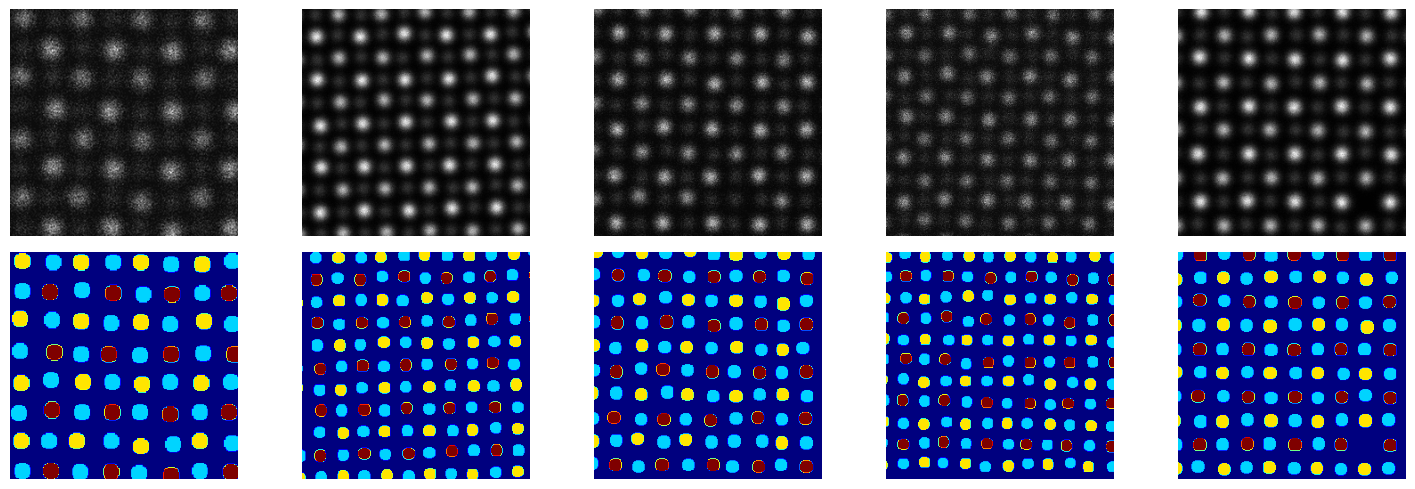

In [6]:
n = 5 # number of images to plot

fig, axs = plt.subplots(2, n, figsize=(15, 5), sharex=True, sharey=True)

for i in range(n):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(labels[i], cmap='jet')
    axs[1, i].axis('off')
fig.tight_layout()

Initialize a nodel for semantic segmentation:

In [7]:
model = aoi.models.Segmentor(nb_classes=4)

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

/Users/austin/miniconda3/envs/atomai_env/lib/python3.12/site-packages/atomai/utils/preproc.py:54: UserWarning: Adding a channel dimension of 1 to training images
  warnings.warn(
/Users/austin/miniconda3/envs/atomai_env/lib/python3.12/site-packages/atomai/utils/preproc.py:59: UserWarning: Adding a channel dimension of 1 to test images
  warnings.warn(


Epoch 1/30 ... Training loss: 1.7513 ... Test loss: 1.5507 ... Train Accuracy: 0.2147 ... Test Accuracy: 0.1906 ... GPU memory usage: N/A / N/A
Epoch 30/30 ... Training loss: 0.7091 ... Test loss: 0.8796 ... Train Accuracy: 0.7952 ... Test Accuracy: 0.4873 ... GPU memory usage: N/A / N/A
Model (final state) evaluation loss: 0.9188
Model (final state) accuracy: 0.4588
Performing stochastic weight averaging...
Model (final state) evaluation loss: 1.4681
Model (final state) accuracy: 0.1891
Plotting training history


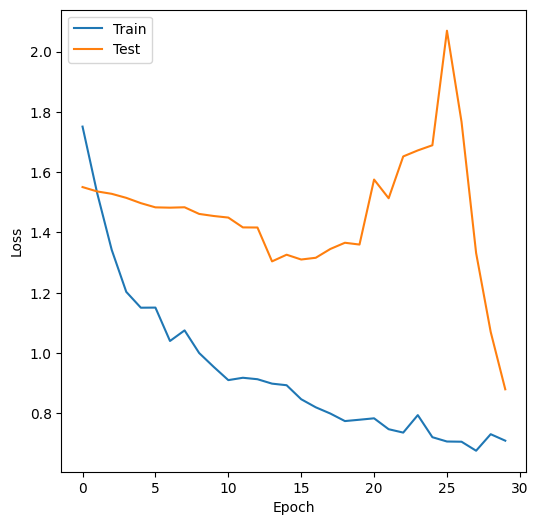

In [8]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True, batch_size=1# training parameters
)

In [ ]:
nn_output, coordinates = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.2056 seconds


Plot raw prediction:

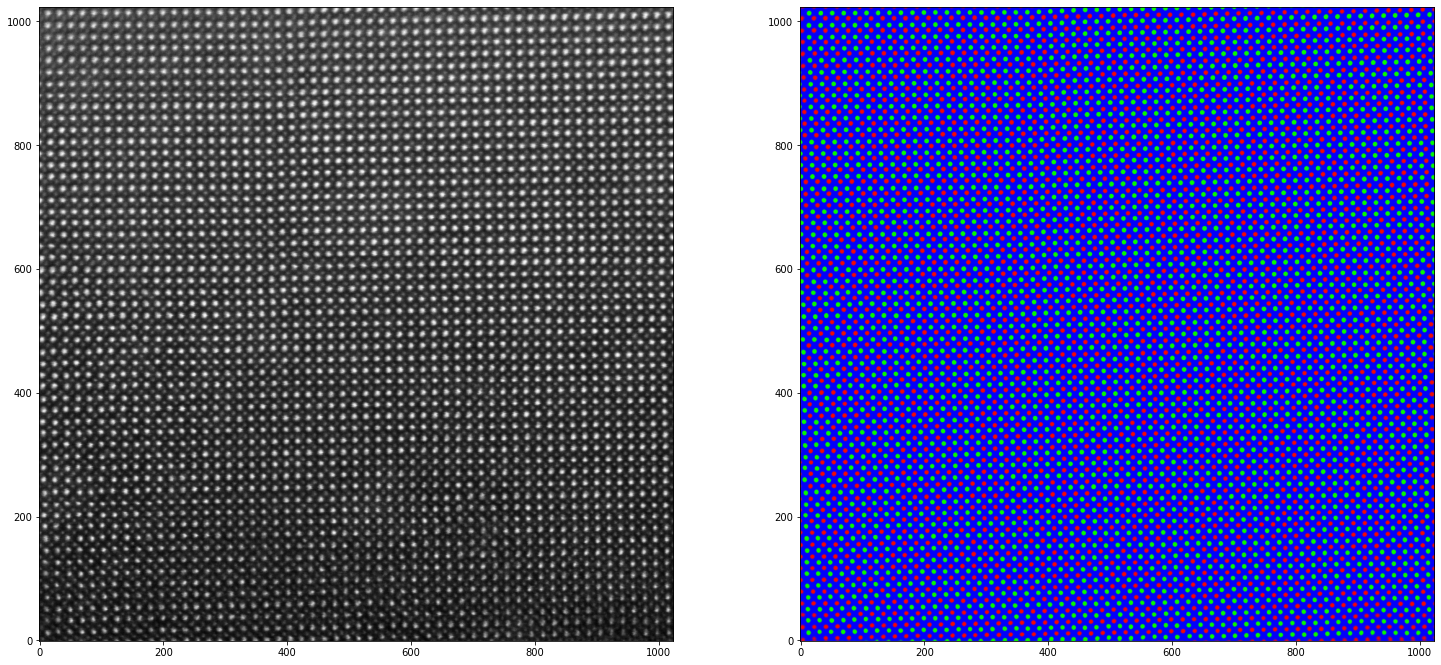

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

Plot atomic coordinates:

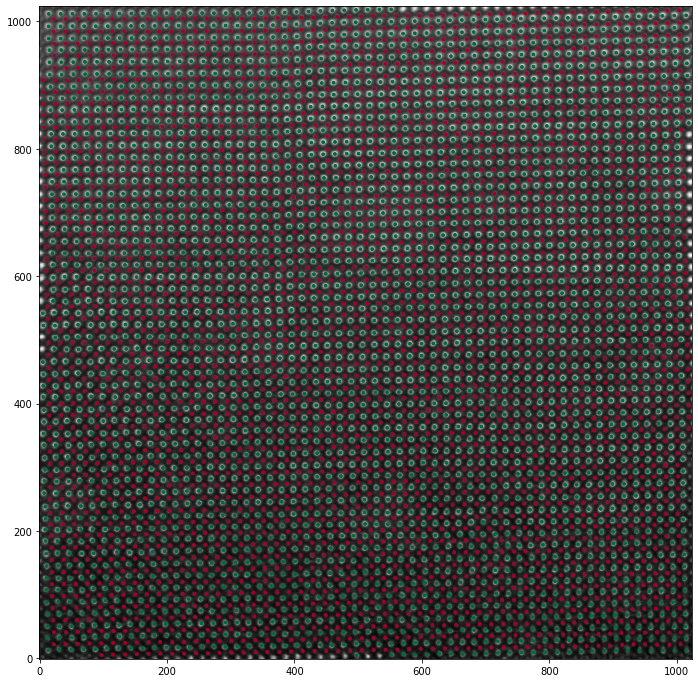

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

### Let's see how noisy we can make the image...

In [ ]:
noise = np.random.normal(0, 0.1, expdata.shape)
noisy_data = expdata + noise

fig, ax = plt.subplots(1, 1)
ax.imshow(noisy_data, cmap='gray')


In [ ]:
nn_output, coordinates = model.predict(noisy_data)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

### AtomAI:
M. Ziatdinov, A. Ghosh, C. Y. Wong, and S. V. Kalinin,

“AtomAI framework for deep learning analysis of image and spectroscopy data in electron and scanning probe microscopy,”

Nature Machine Intelligence 2022 4:12, vol. 4, no. 12, pp. 1101–1112, Dec. 2022, doi: 10.1038/s42256-022-00555-8.